Перед запуском убедитесь, что в корне проекта есть файл .env и в нем заполнены выданные вам креды подключения к базам данных и хранилищу

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import pandas as pd
from dotenv import load_dotenv, find_dotenv
from sqlalchemy import create_engine
import matplotlib.pyplot as plt
import numpy as np

/tmp/ipykernel_115411/3440723236.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [3]:
# подгружаем .env
load_dotenv(dotenv_path = '/home/mle-user/mle_projects/mle-project-sprint-1-v001/part1_airflow/.env')

True

In [4]:
# Считываем все креды
src_host = os.environ.get('DB_SOURCE_HOST')
src_port = os.environ.get('DB_SOURCE_PORT')
src_username = os.environ.get('DB_SOURCE_USER')
src_password = os.environ.get('DB_SOURCE_PASSWORD')
src_db = os.environ.get('DB_SOURCE_NAME') 

dst_host = os.environ.get('DB_DESTINATION_HOST')
dst_port = os.environ.get('DB_DESTINATION_PORT')
dst_username = os.environ.get('DB_DESTINATION_USER')
dst_password = os.environ.get('DB_DESTINATION_PASSWORD')
dst_db = os.environ.get('DB_DESTINATION_NAME')

s3_bucket = os.environ.get('S3_BUCKET_NAME')
s3_access_key = os.environ.get('AWS_ACCESS_KEY_ID')
s3_secret_access_key = os.environ.get('AWS_SECRET_ACCESS_KEY')

In [5]:
# Создадим соединения
src_conn = create_engine(f'postgresql://{src_username}:{src_password}@{src_host}:{src_port}/{src_db}')
dst_conn = create_engine(f'postgresql://{dst_username}:{dst_password}@{dst_host}:{dst_port}/{dst_db}')


In [6]:
# Пример выгрузки данных из БД
TABLE = 'flats_churn'
SQL = f'select * from {TABLE}'
data = pd.read_sql(SQL, dst_conn)

А дальше, творите!

In [7]:
display (data.head())

,id_key,id,building_id,floor,kitchen_area,living_area,rooms,is_apartment,studio,total_area,price,build_year,building_type_int,latitude,longitude,ceiling_height,flats_count,floors_total,has_elevator
0,1,0,6220,9,9.9,19.900000,1,false,false,35.099998,9500000.0,1965,6,55.71711349487305,37.78112030029297,2.64,84,12,true
1,2,1,18012,7,0.0,16.600000,1,false,false,43.000000,13500000.0,2001,2,55.79484939575195,37.60801315307617,3.00,97,10,true
2,3,2,17821,9,9.0,32.000000,2,false,false,56.000000,13500000.0,2000,4,55.74003982543945,37.7617416381836,2.70,80,10,true
3,4,3,18579,1,10.1,43.099998,3,false,false,76.000000,20000000.0,2002,4,55.67201614379883,37.57087707519531,2.64,771,17,true
4,5,4,9293,3,3.0,14.000000,1,false,false,24.000000,5200000.0,1971,1,55.80880737304688,37.707305908203125,2.60,208,9,true


141362
17425
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 141362 entries, 0 to 141361
Data columns (total 19 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   id_key             141362 non-null  int64  
 1   id                 141362 non-null  object 
 2   building_id        141362 non-null  object 
 3   floor              141362 non-null  int64  
 4   kitchen_area       141362 non-null  float64
 5   living_area        141362 non-null  float64
 6   rooms              141362 non-null  int64  
 7   is_apartment       141362 non-null  object 
 8   studio             141362 non-null  object 
 9   total_area         141362 non-null  float64
 10  price              141362 non-null  float64
 11  build_year         141362 non-null  int64  
 12  building_type_int  141362 non-null  object 
 13  latitude           141362 non-null  object 
 14  longitude          141362 non-null  object 
 15  ceiling_height     141362 non-null  fl

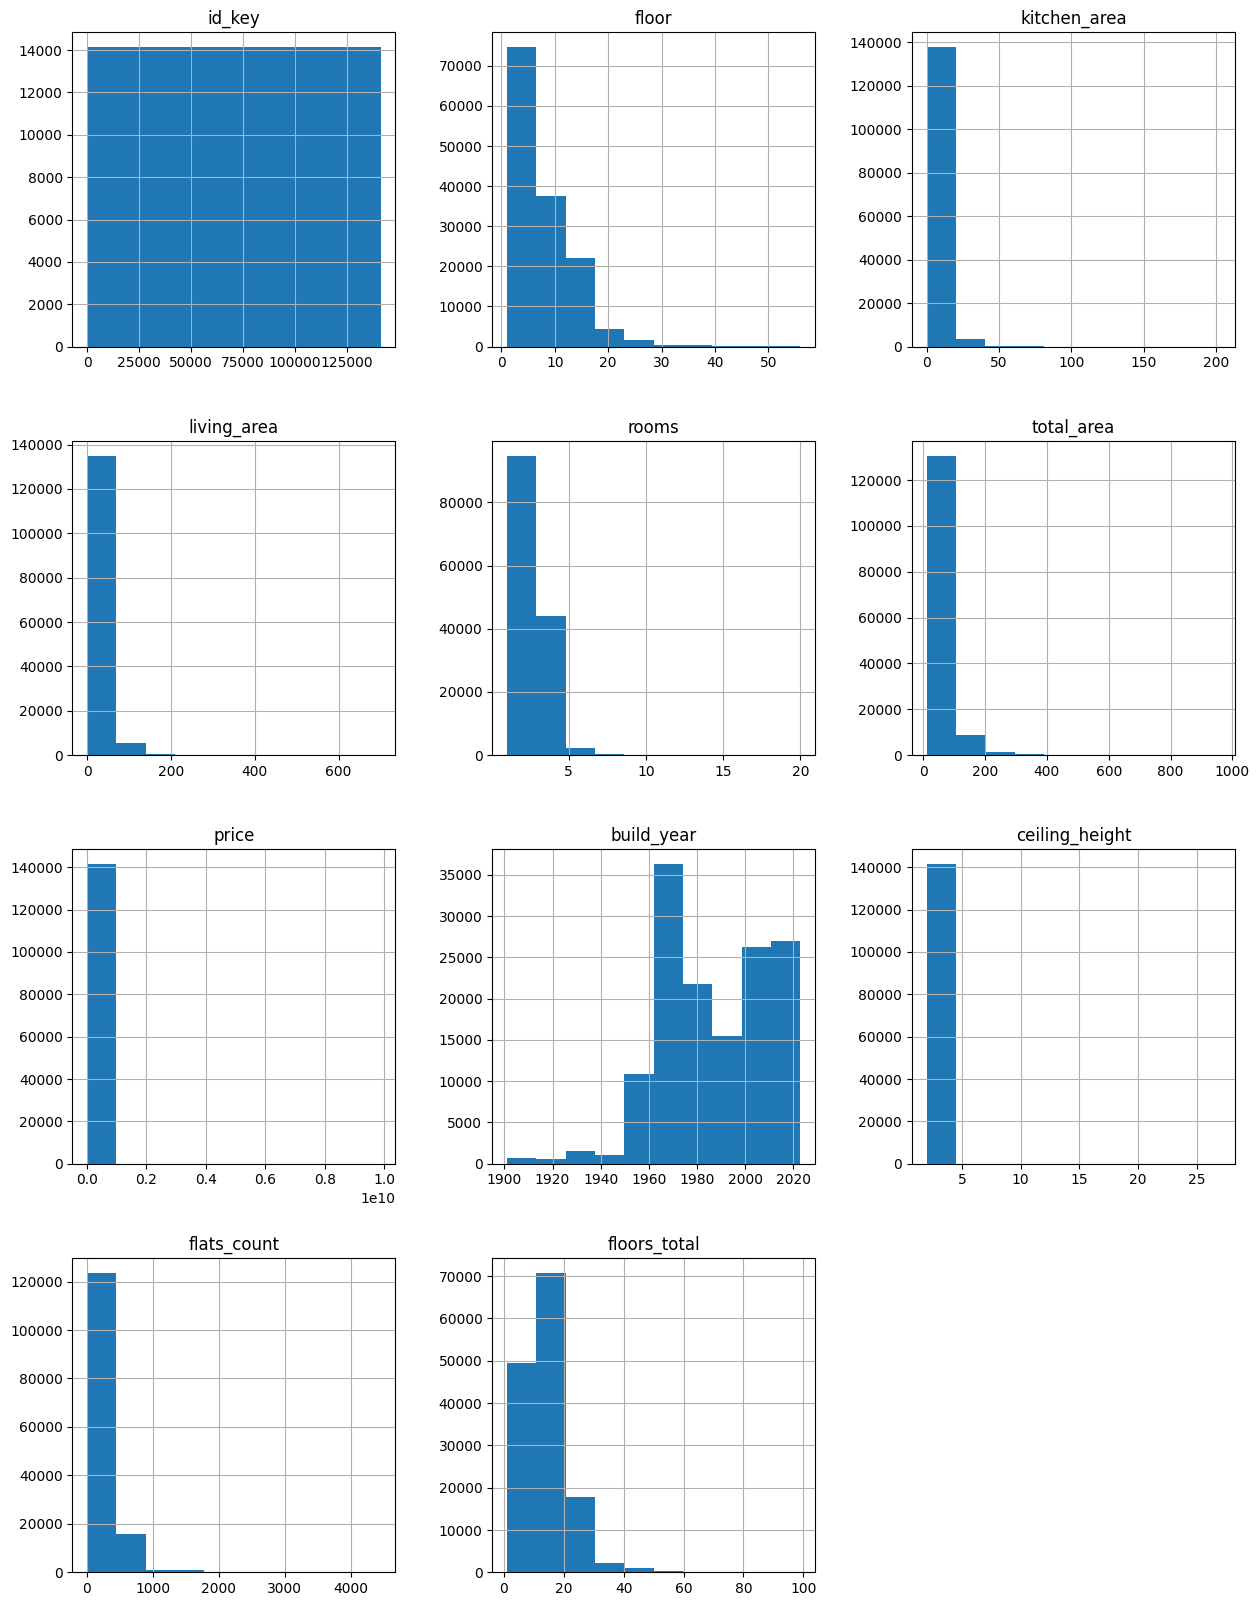

In [8]:
data_w = data.copy()
old_data_shape = data.shape[0] #сохраним размер первоначальной выборки
print (old_data_shape)
feature_cols = ['building_id', 'floor', 'kitchen_area', 'living_area', 'rooms', 'is_apartment', 'studio', 'total_area', 'price', 'build_year',
                'building_type_int', 'latitude', 'longitude', 'ceiling_height', 'flats_count', 'floors_total', 'has_elevator']
#feature_cols = data_w.columns.drop('id_key','id').tolist()
is_duplicated_features = data_w.duplicated(subset=feature_cols, keep=False)
print(len(data_w[is_duplicated_features]))
data_w.info()
data.hist(figsize=(15, 20));

Пропуски в датасете отсутсвуют, однако выявлены дубликаты и аномалии в числовых данных. Дубликаты удалим, аномалии рассмотрим подробнее и устраним

In [9]:
data_w = data_w[~is_duplicated_features].reset_index(drop=True)

In [10]:
print(len(data_w[data_w['floor'] > data_w['floors_total']]))
print(data_w['floor'].describe())

0
count    123937.000000
mean          7.443806
std           5.689226
min           1.000000
25%           3.000000
50%           6.000000
75%          10.000000
max          56.000000
Name: floor, dtype: float64


Убедился, что этаж квартиры не превышает колличество этажей в доме

In [11]:
print(data_w['ceiling_height'].describe())

count    123937.000000
mean          2.750417
std           0.222623
min           2.000000
25%           2.640000
50%           2.640000
75%           2.800000
max          27.000000
Name: ceiling_height, dtype: float64


In [12]:
display (data_w[data_w['ceiling_height'] >= 10])

,id_key,id,building_id,floor,kitchen_area,living_area,rooms,is_apartment,studio,total_area,price,build_year,building_type_int,latitude,longitude,ceiling_height,flats_count,floors_total,has_elevator
73401,83674,83673,3852,1,6.0,18.799999,1,false,false,31.700001,9000000.0,1961,1,55.86765670776367,37.66957473754883,27.0,60,5,false


Видим одну анамалию в признаке высоты потолка, запись в целом верная, но данные по высете потолка вероятно занесены с ошибкой порядка. восстановим данные.

In [13]:
data_w.loc[data_w['ceiling_height'] >= 20, 'ceiling_height'] /= 10
display (data_w[data_w['id_key'] == 83674])

,id_key,id,building_id,floor,kitchen_area,living_area,rooms,is_apartment,studio,total_area,price,build_year,building_type_int,latitude,longitude,ceiling_height,flats_count,floors_total,has_elevator
73401,83674,83673,3852,1,6.0,18.799999,1,false,false,31.700001,9000000.0,1961,1,55.86765670776367,37.66957473754883,2.7,60,5,false


In [14]:
display(data_w['floors_total'].describe())

count    123937.000000
mean         14.044789
std           6.862320
min           1.000000
25%           9.000000
50%          14.000000
75%          17.000000
max          99.000000
Name: floors_total, dtype: float64

In [15]:
display (data_w[data_w['floors_total'] >= 60])

,id_key,id,building_id,floor,kitchen_area,living_area,rooms,is_apartment,studio,total_area,price,build_year,building_type_int,latitude,longitude,ceiling_height,flats_count,floors_total,has_elevator
8969,9827,9826,9465,4,6.00,30.000000,2,false,false,45.299999,10400000.0,1971,4,55.723480224609375,37.81874847412109,2.64,215,99,true
42709,48597,48596,9567,3,6.50,21.000000,1,false,false,34.900002,8500000.0,1971,4,55.82910537719727,37.52186584472656,2.64,214,81,true
52453,59766,59765,24040,12,14.16,43.400002,3,false,false,84.839996,11905683.0,2018,2,55.55776596069336,37.555023193359375,2.80,1623,70,true
88305,100774,100773,19284,6,29.00,0.000000,5,false,false,226.000000,178963008.0,2004,3,55.706092834472656,37.54970550537109,3.50,80,60,true
119244,135973,135972,24199,30,0.00,0.000000,2,false,false,67.000000,55000000.0,2018,2,55.77080535888672,37.564212799072266,3.00,1630,66,true


In [16]:
display (data_w[data_w['latitude'] == '55.723480224609375'])

,id_key,id,building_id,floor,kitchen_area,living_area,rooms,is_apartment,studio,total_area,price,build_year,building_type_int,latitude,longitude,ceiling_height,flats_count,floors_total,has_elevator
8969,9827,9826,9465,4,6.0,30.000000,2,false,false,45.299999,10400000.0,1971,4,55.723480224609375,37.81874847412109,2.64,215,99,true
10130,11149,11148,9464,8,8.4,38.700001,3,false,false,60.000000,11700000.0,1971,4,55.723480224609375,37.81874847412109,2.64,215,9,true
10476,11525,11524,9464,1,7.2,50.000000,3,false,false,70.400002,6990000.0,1971,4,55.723480224609375,37.81874847412109,2.64,215,9,true
17903,20200,20199,9464,1,11.0,0.000000,3,false,false,60.799999,12200000.0,1971,4,55.723480224609375,37.81874847412109,2.64,215,9,true
20634,23350,23349,9464,9,6.4,19.799999,1,false,false,34.700001,8200000.0,1971,4,55.723480224609375,37.81874847412109,2.64,215,9,true
27680,31086,31085,9464,4,8.0,40.000000,3,false,false,62.000000,8500000.0,1971,4,55.723480224609375,37.81874847412109,2.64,215,9,true
29750,33631,33630,9464,7,6.6,19.799999,1,false,false,35.299999,6400000.0,1971,4,55.723480224609375,37.81874847412109,2.64,215,9,true
35853,40726,40725,9464,2,6.1,29.700001,2,false,false,45.799999,9200000.0,1971,4,55.723480224609375,37.81874847412109,2.64,215,9,true
55896,63700,63699,9464,2,6.1,29.700001,2,false,false,45.799999,9150000.0,1971,4,55.723480224609375,37.81874847412109,2.64,215,9,true
56134,63964,63963,9464,2,6.8,20.900000,1,false,false,36.299999,8500000.0,1971,4,55.723480224609375,37.81874847412109,2.64,215,9,true


замечена аномалия опечатки - из типовой записи видно что дом с одинаковыми координатами имеет этажность 9 но в одном случае эта этажность занесена как 99. кроме того эта аномалия стала причиной создания когда один дом имеет несколько ID. чтобы исправить аналогичные опечатки применим метод transform с медианой по группе. группировку будем производить по широте и долготе, приняв ее уникальной для каждого дома.

In [17]:
data_w['floors_total'] = np.ceil(data_w.groupby(['latitude', 'longitude'])['floors_total'].transform("median"))

In [18]:
display (data_w[data_w['latitude'] == '55.723480224609375'])

,id_key,id,building_id,floor,kitchen_area,living_area,rooms,is_apartment,studio,total_area,price,build_year,building_type_int,latitude,longitude,ceiling_height,flats_count,floors_total,has_elevator
8969,9827,9826,9465,4,6.0,30.000000,2,false,false,45.299999,10400000.0,1971,4,55.723480224609375,37.81874847412109,2.64,215,9.0,true
10130,11149,11148,9464,8,8.4,38.700001,3,false,false,60.000000,11700000.0,1971,4,55.723480224609375,37.81874847412109,2.64,215,9.0,true
10476,11525,11524,9464,1,7.2,50.000000,3,false,false,70.400002,6990000.0,1971,4,55.723480224609375,37.81874847412109,2.64,215,9.0,true
17903,20200,20199,9464,1,11.0,0.000000,3,false,false,60.799999,12200000.0,1971,4,55.723480224609375,37.81874847412109,2.64,215,9.0,true
20634,23350,23349,9464,9,6.4,19.799999,1,false,false,34.700001,8200000.0,1971,4,55.723480224609375,37.81874847412109,2.64,215,9.0,true
27680,31086,31085,9464,4,8.0,40.000000,3,false,false,62.000000,8500000.0,1971,4,55.723480224609375,37.81874847412109,2.64,215,9.0,true
29750,33631,33630,9464,7,6.6,19.799999,1,false,false,35.299999,6400000.0,1971,4,55.723480224609375,37.81874847412109,2.64,215,9.0,true
35853,40726,40725,9464,2,6.1,29.700001,2,false,false,45.799999,9200000.0,1971,4,55.723480224609375,37.81874847412109,2.64,215,9.0,true
55896,63700,63699,9464,2,6.1,29.700001,2,false,false,45.799999,9150000.0,1971,4,55.723480224609375,37.81874847412109,2.64,215,9.0,true
56134,63964,63963,9464,2,6.8,20.900000,1,false,false,36.299999,8500000.0,1971,4,55.723480224609375,37.81874847412109,2.64,215,9.0,true


In [19]:
display(data_w['floors_total'].describe())

count    123937.00000
mean         14.11685
std           6.83218
min           1.00000
25%           9.00000
50%          14.00000
75%          17.00000
max          56.00000
Name: floors_total, dtype: float64

In [20]:
display (data_w[data_w['floors_total'] >= 50])

,id_key,id,building_id,floor,kitchen_area,living_area,rooms,is_apartment,studio,total_area,price,build_year,building_type_int,latitude,longitude,ceiling_height,flats_count,floors_total,has_elevator
384,430,429,23081,33,0.0,0.000000,3,false,false,119.900002,31987250.0,2015,2,55.835487365722656,37.658348083496094,3.10,356,56.0,true
1552,1711,1710,3172,5,5.5,18.500000,1,false,false,30.200001,11400000.0,1960,1,55.734283447265625,37.48701858520508,2.48,80,54.0,false
1686,1857,1856,23083,33,0.0,124.199997,3,false,false,165.600006,39931984.0,2015,2,55.835487365722656,37.658348083496094,3.10,356,56.0,true
3055,3431,3430,23083,5,0.0,96.080002,2,false,false,128.100006,35879888.0,2015,2,55.835487365722656,37.658348083496094,3.10,356,56.0,true
3336,3730,3729,23081,46,0.0,126.000000,3,false,false,138.600006,24240308.0,2015,2,55.835487365722656,37.658348083496094,3.10,356,56.0,true
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
122071,139117,139116,23081,16,0.0,126.090912,3,false,false,138.699997,22486322.0,2015,2,55.835487365722656,37.658348083496094,3.10,356,56.0,true
122470,139566,139565,23077,6,6.0,21.000000,1,false,false,33.000000,9150000.0,2015,2,55.835487365722656,37.658348083496094,3.10,356,56.0,true
122565,139675,139674,23079,30,15.0,40.000000,2,false,false,69.000000,14950000.0,2015,2,55.835487365722656,37.658348083496094,3.10,356,56.0,true
122569,139679,139678,23079,29,0.0,0.000000,2,false,false,96.900002,18054312.0,2015,2,55.835487365722656,37.658348083496094,3.10,356,56.0,true


In [21]:
print(len(data_w[data_w['kitchen_area']+data_w['living_area'] > data_w['total_area']]))
display(data_w[data_w['kitchen_area']+data_w['living_area'] > data_w['total_area']])

145


,id_key,id,building_id,floor,kitchen_area,living_area,rooms,is_apartment,studio,total_area,price,build_year,building_type_int,latitude,longitude,ceiling_height,flats_count,floors_total,has_elevator
449,499,498,4645,5,19.5,19.500000,1,false,false,32.000000,8050000.0,1962,6,55.80606842041016,37.58137130737305,2.64,64,9.0,true
517,573,572,23441,2,21.0,65.000000,3,false,false,72.900002,17800000.0,2016,3,55.569942474365234,37.48762130737305,3.00,297,12.0,true
1041,1153,1152,687,4,6.0,66.000000,3,false,false,67.000000,35000000.0,1933,1,55.77871322631836,37.66530990600586,4.00,161,8.0,true
1476,1632,1631,22656,7,12.0,53.200001,3,false,false,65.199997,16990000.0,2014,2,55.64213943481445,37.60444641113281,3.00,213,21.0,false
1496,1652,1651,7101,9,7.7,25.400000,1,false,false,33.099998,20000000.0,1967,4,55.70672225952149,37.674015045166016,2.70,251,9.0,true
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
121151,138073,138072,23170,11,13.0,58.400002,2,false,false,62.000000,16300000.0,2015,4,55.60273361206055,37.367435455322266,2.74,462,17.0,true
121554,138546,138545,21823,8,40.0,80.000000,3,false,false,103.800000,30749912.0,2011,2,55.67753982543945,37.6343994140625,3.00,869,33.0,true
121578,138571,138570,23433,4,17.0,46.200001,1,false,false,55.930000,12899990.0,2016,3,55.46817398071289,37.28944396972656,3.00,123,6.0,true
122757,139881,139880,2110,4,32.0,51.400002,3,false,false,77.500000,15600000.0,1958,1,55.68069839477539,37.56353759765625,3.00,69,5.0,false


In [22]:
# Условие для удаления строк
condition = data_w['kitchen_area']+data_w['living_area'] > data_w['total_area']

# Удаление строк, удовлетворяющих условию
data_w = data_w[~condition]

In [23]:
display(data_w['kitchen_area'].describe())
display(data_w['living_area'].describe())
display(data_w['total_area'].describe())
display (len(data_w[(data_w['living_area'] == 0) & (data_w['kitchen_area'] == 0)]))

count    123792.000000
mean          8.929257
std           5.156431
min           0.000000
25%           6.100000
50%           8.700000
75%          10.200000
max         203.000000
Name: kitchen_area, dtype: float64

count    123792.000000
mean         30.912384
std          23.400568
min           0.000000
25%          19.000000
50%          29.379999
75%          41.000000
max         700.000000
Name: living_area, dtype: float64

count    123792.000000
mean         61.735717
std          39.322379
min          11.000000
25%          39.099998
50%          52.500000
75%          71.000000
max         920.000000
Name: total_area, dtype: float64

7380

In [24]:
# Условие для удаления строк
condition = (data_w['living_area'] == 0) & (data_w['kitchen_area'] == 0)

# Удаление строк, удовлетворяющих условию
data_w = data_w[~condition]

count    1.164120e+05
mean     2.613297e+05
std      1.013896e+06
min      2.619048e-01
25%      1.911818e+05
50%      2.326007e+05
75%      2.839506e+05
max      2.648649e+08
Name: price_metr, dtype: float64

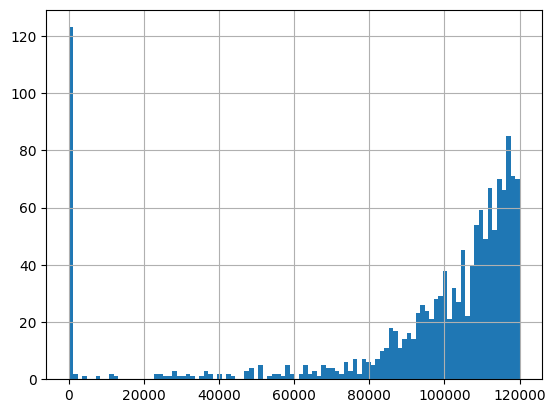

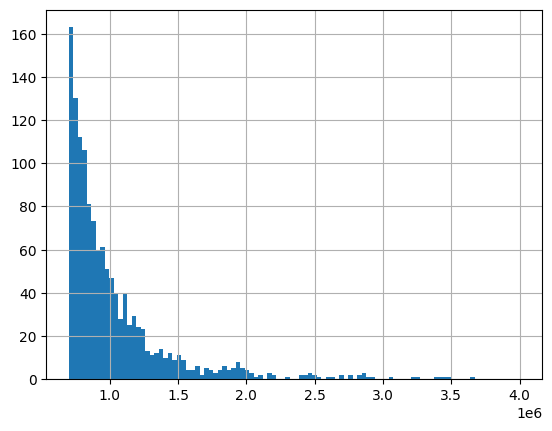

In [25]:
#data_w['price_metr'] = data_w['price']/data_w['total_area']
display(data_w['price_metr'].describe())
data_w['price_metr'].hist(bins=100, range=(0,120000))
plt.show()
data_w['price_metr'].hist(bins=100, range=(700000,4000000))
plt.show()

In [26]:
# Условие для удаления строк
condition = (data_w['price_metr'] <= 80000) | (data_w['price_metr'] >= 1200000)

# Удаление строк, удовлетворяющих условию
data_w = data_w[~condition]

In [27]:
display(data_w['rooms'].describe())
display (data_w[data_w['rooms'] > 10])


count    115907.000000
mean          2.089477
std           0.947043
min           1.000000
25%           1.000000
50%           2.000000
75%           3.000000
max          17.000000
Name: rooms, dtype: float64

,id_key,id,building_id,floor,kitchen_area,living_area,rooms,is_apartment,studio,total_area,price,build_year,building_type_int,latitude,longitude,ceiling_height,flats_count,floors_total,has_elevator,price_metr
18864,21484,21483,19932,29,0.0,403.0,12,false,false,629.0,199000000.0,2006,0,55.67082977294922,37.51688766479492,3.0,154,30.0,true,316375.198728
57207,65209,65208,19932,29,203.0,403.0,12,false,false,629.0,115000000.0,2006,0,55.67082977294922,37.51688766479492,3.0,154,30.0,true,182829.888712
73001,83210,83209,2267,1,20.0,170.0,17,true,false,417.0,45000000.0,1958,1,55.75661849975586,37.65399169921875,3.0,105,7.0,true,107913.669065
98029,111913,111912,2357,5,36.0,430.0,16,false,false,598.0,99950000.0,1958,1,55.79738235473633,37.68766021728516,3.1,16,6.0,false,167140.468227


In [32]:
display(data_w['has_elevator'].describe())

count     115907
unique         2
top         true
freq      103850
Name: has_elevator, dtype: object

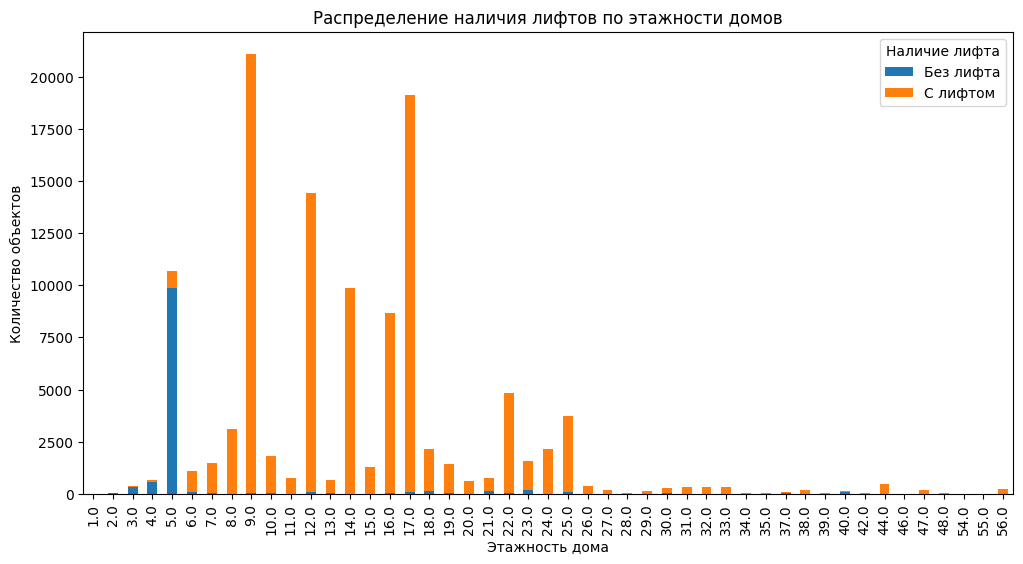

In [29]:
# Группировка данных по 'floors_total' с подсчётом количества лифтов
elevator_counts = data_w.groupby(['floors_total', 'has_elevator']).size().unstack(fill_value=0)

# Построение гистограммы
elevator_counts.plot(kind='bar', stacked=True, figsize=(12, 6))
plt.title('Распределение наличия лифтов по этажности домов')
plt.xlabel('Этажность дома')
plt.ylabel('Количество объектов')
plt.legend(title='Наличие лифта', labels=['Без лифта', 'С лифтом'])
plt.show()

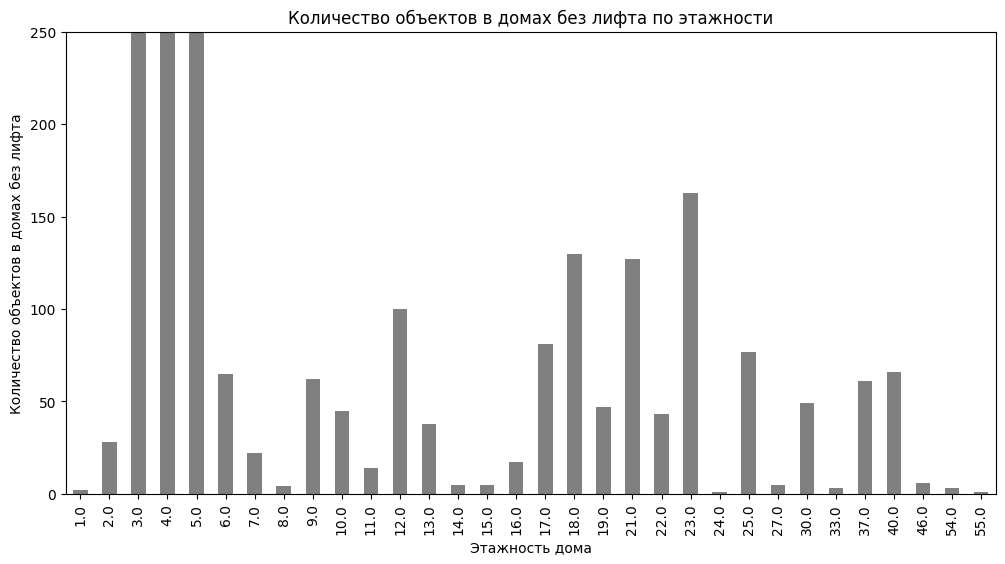

In [30]:
# Группировка данных по 'floors_total' с подсчётом количества лифтов
elevator_no_counts = data_w[data_w['has_elevator'] == 'false'].groupby('floors_total').size()

# Построение гистограммы
elevator_no_counts.plot(kind='bar', figsize=(12, 6), color='gray')
plt.title('Количество объектов в домах без лифта по этажности')
plt.xlabel('Этажность дома')
plt.ylabel('Количество объектов в домах без лифта')
plt.ylim(0, 250)
plt.show()

In [31]:
new_data_shape = data_w.shape[0] #сохраним размер первоначальной выборки
print('Размер первоначальной выборки', old_data_shape)
print('Размер выборки после очистки', new_data_shape)
print('Доля потерь данных после очистки', (old_data_shape-new_data_shape)/old_data_shape)

Размер первоначальной выборки 141362
Размер выборки после очистки 115907
Доля потерь данных после очистки 0.18006960852279963
